# Explore Phase

we will do 
- implement functions that we will use 
- load data 
- check null values 
- show histograms 
- show boxplots 
- show corelation matrix 
- scatter plot 
- look at measurement of time for different pollutants at different stations 

In [1]:
! pip install folium
! pip install colour

In [2]:
# imports 

import numpy as np 
import pandas as pd 
import re 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ipywidgets as widgets 
from ipywidgets import interact 
import folium 
from colour import Color
from collections import defaultdict
from typing import List 


In [3]:
# init variable 

categorical_variables  = ['Station']
pollutants_list = ['PM2.5' , 'PM10' , 'NO' ,'NO2' , 'NOX' , 'CO' ,'OZONO']

FONT_SIZE_TICKS = 12 
FONT_SIZE_TITLE = 20
FONT_SIZE_AXES  = 16 

In [4]:
# implement functions 



# create histogram plot 


def create_histogram_plot(df: pd.core.frame.DataFrame , bins =int):
    
    def interactive_hist_plot(station , pollutant):
        data = df[df.Station==station]
        X    = data[pollutant].values
        try:
            plt.figure(figsize=(12,6))
            plt.xlabel(f'{pollutant} concentration' , fontsize = FONT_SIZE_AXES)
            plt.ylabel('Number of measurments' , fontsize = FONT_SIZE_AXES)
            plt.hist(X , bins=bins)
            plt.title(f'pollutant - {pollutant} - station {station}' , fontsize=FONT_SIZE_TITLE)
            plt.xticks(fontsize = FONT_SIZE_TICKS)
            plt.yticks(fontsize = FONT_SIZE_TICKS)
            plt.show()
            
        except ValueError:
            print('Histogram cannot be shown for selected values as there is no data')
    # now let's do some widgets 
    
    station_widget  = widgets.Dropdown(
         options   = df.Station.unique(),
         discrition= 'Station'
    
    ) 
    pollutant_widget= widgets.Dropdown(
    
         options    = pollutants_list,
         discription= 'pollutant'
    )
        
        # collect all in interact layer 
    interact(interactive_hist_plot , station = station_widget , pollutant= pollutant_widget)
    
    
    

# create box plot 

def create_boxplot(df: pd.core.frame.DataFrame):
    
    labels = df[categorical_variables[0]].unique()
    
    def _interactive_boxplot(cat_var):
        medians = []
        for value in df[categorical_variables[0]].unique():
            median = 1000
            try:
                rows = df[cat_var].loc[df[categorical_variables[0]]==value]
                if rows.isnull().sum() != rows.shape[0]:
                    median = rows.median()
            except:
                print('Wrong')
            medians.append(median)
        orderInd = np.argsort(medians) 
        
        plt.figure(figsize=(17,7))
        scale = 'linear'
        plt.yscale(scale)
        sns.boxplot(data=df, y=cat_var, x='Station', order=labels[orderInd], color="seagreen")
        plt.title(f'Distributions of {cat_var}', fontsize=FONT_SIZE_TITLE)
        plt.xlabel('Station', fontsize=FONT_SIZE_AXES)
        plt.ylabel(f'{cat_var} concentration', fontsize=FONT_SIZE_AXES)
        plt.xticks(fontsize=FONT_SIZE_TICKS)
        plt.yticks(fontsize=FONT_SIZE_TICKS)
        plt.show()
        
    count_widget = widgets.Dropdown(  
    
        options = pollutants_list ,
        discription = 'pollutant'
    
    )
                
    interact(_interactive_boxplot , cat_var = count_widget)
    

# create scatter plot 

def create_scatter_plot(df: pd.core.frame.DataFrame):
    
    
    df = df[pollutants_list]
    df_clean =df.dropna(inplace=False)
    def interactive_scatter(var_x, var_y):
        x = df_clean[var_x].values
        y = df_clean[var_y].values
        bins = [200,200]
        
        hh , locx ,locy = np.histogram2d(x,y , bins=bins)
        z = np.array(  [hh[ np.argmax(a<=locx[1:]) , np.argmax(b<=locy[1:]) ] for a,b in zip( x,y)]  )
        idx = z.argsort()
        x2 ,y2 ,z2 = x[idx] , y[idx] ,z[idx]
        fig ,ax = plt.subplots(figsize=(15,6))
        s = ax.scatter(x2,y2 ,c =z2 ,cmap='jet' , marker ='.' ,s=1)
        
        ax.set_title(f'{var_x} vs {var_y} (color indicates density of points)' , fontsize = FONT_SIZE_TITLE)
        ax.set_xlabel(f'{var_x} concenteration ', fontsize = FONT_SIZE_AXES)
        ax.set_ylabel(f'{var_y} concenteration ', fontsize = FONT_SIZE_AXES)
        ax.tick_params(labelsize = FONT_SIZE_TICKS)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right' , size='5%' , pad =0.05)
        
        fig.colorbar( 
        s , 
        cax = cax ,
        cmap ='jet',
        values = z2 ,
        orientation = 'vertical'   
        
        )
        plt.show()
    count_x_widget =  widgets.Dropdown(
    
        options = pollutants_list,
        discription ='X-axis'
    
    )
    count_y_widget = widgets.Dropdown(
    
        options = pollutants_list ,
        discription = 'Y-axis' ,
        value = 'PM10'
        
    )
    interact( interactive_scatter , var_x =count_x_widget , var_y= count_y_widget)

# plot pair plot 

def create_plot_pair(df: pd.core.frame.DataFrame , pollutants_list:List[str]):
    
    
    with sns.plotting_context(rc={'axes.labelsize': FONT_SIZE_AXES}):
        sns.pairplot(df[pollutants_list] , kind='hist')
    plt.show()


# create correlation matrix

def create_correlation(df:pd.core.frame.DataFrame , pollutants_list:List[str]    ):
    
    
    plt.figure(figsize = (10,10))
    sns.heatmap( df[pollutants_list].corr() , 
                   square=True,
        annot=True,
        cbar=False,
        cmap="YlGnBu",
        vmin=-1,
        vmax=1)
    plt.show


# create time series plot 

def create_time_series(df:pd.core.frame.DataFrame , start:str , end:str):
    
    def _interactive_time_series_plot(station, pollutant, date_range):
        data = df[df.Station==station]
        data = data[data.DateTime > date_range[0]]
        data = data[data.DateTime < date_range[1]]
        plt.figure(figsize=(12, 6))
        plt.plot(data["DateTime"],data[pollutant], '-')
        plt.title(f'Temporal change of {pollutant}', fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f'{pollutant} concentration', fontsize=FONT_SIZE_AXES)
        plt.xticks(rotation=20, fontsize=FONT_SIZE_TICKS)
        plt.yticks(fontsize=FONT_SIZE_TICKS)
        plt.show()
    
    # Widget for picking the station
    station_selection = widgets.Dropdown(
        options=df.Station.unique(),
        description='Station'
    )

    # Widget for picking the pollutant
    pollutant_selection = widgets.Dropdown(
        options=pollutants_list,
        description='Pollutant',
    )

    dates = pd.date_range(start_date, end_date, freq='D')

    options = [(date.strftime(' %d/%m/%Y '), date) for date in dates]
    index = (0, len(options)-1)
    
    # Slider for picking the dates
    selection_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description='Dates',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    # Putting it all together
    interact(_interactive_time_series_plot, station=station_selection, pollutant=pollutant_selection, date_range=selection_range_slider);
    
# fixed dates 


def fix_dates(df: pd.core.frame.DataFrame, date_column: str) -> List[str]:
    '''Fixes the date format in the dataframe.

    Args:
        df (pd.core.frame.DataFrame): The dataframe.
        date_column (str): Column with dates
        
    Returns:
        fixed_dates (List[str]): list of corrected dates to be put into the dataframe
    '''
    dates = df[date_column]
    fixed_dates = []
    for row in dates:
        line = list(row)
        hour = int(''.join(line[11:13])) - 1
        fixed_dates.append("".join(line[:11] + [str(int(hour/10)) + str(int(hour % 10))] + line[13:]))
    return fixed_dates


In [5]:
# load data and show  it 

data_path  = 'E:\\projects\\air_quality\\data\\RMCAB_air_quality_sensor_data.csv'

data  = pd.read_csv(data_path)

data.head()

,PM10,PM2.5,NO,NO2,NOX,CO,OZONO,Station,DateTime
0,56.6,32.7,7.504,15.962,23.493,0.44924,2.431,USM,01-01-2021 01:00
1,59.3,39.3,16.560,17.866,34.426,0.69832,1.121,USM,01-01-2021 02:00
2,96.4,70.8,22.989,17.802,40.791,0.88243,1.172,USM,01-01-2021 03:00
3,108.3,81.0,3.704,9.886,13.591,0.29549,6.565,USM,01-01-2021 04:00
4,87.7,56.1,2.098,9.272,11.371,0.16621,9.513,USM,01-01-2021 05:00


In [6]:
# show nulls 


data.isnull().sum()

PM10        20014
PM2.5       15312
NO          27664
NO2         27662
NOX         27668
CO          31238
OZONO       32132
Station         0
DateTime        0
dtype: int64

# Test Functions

In [7]:
# let's test our functions 


number_of_bins = 64 
create_histogram_plot(data , number_of_bins)

interactive(children=(Dropdown(description='station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

In [8]:
# show box plot 


create_boxplot(data)


interactive(children=(Dropdown(description='cat_var', options=('PM2.5', 'PM10', 'NO', 'NO2', 'NOX', 'CO', 'OZO…

In [9]:
create_scatter_plot(data)

interactive(children=(Dropdown(description='var_x', options=('PM2.5', 'PM10', 'NO', 'NO2', 'NOX', 'CO', 'OZONO…

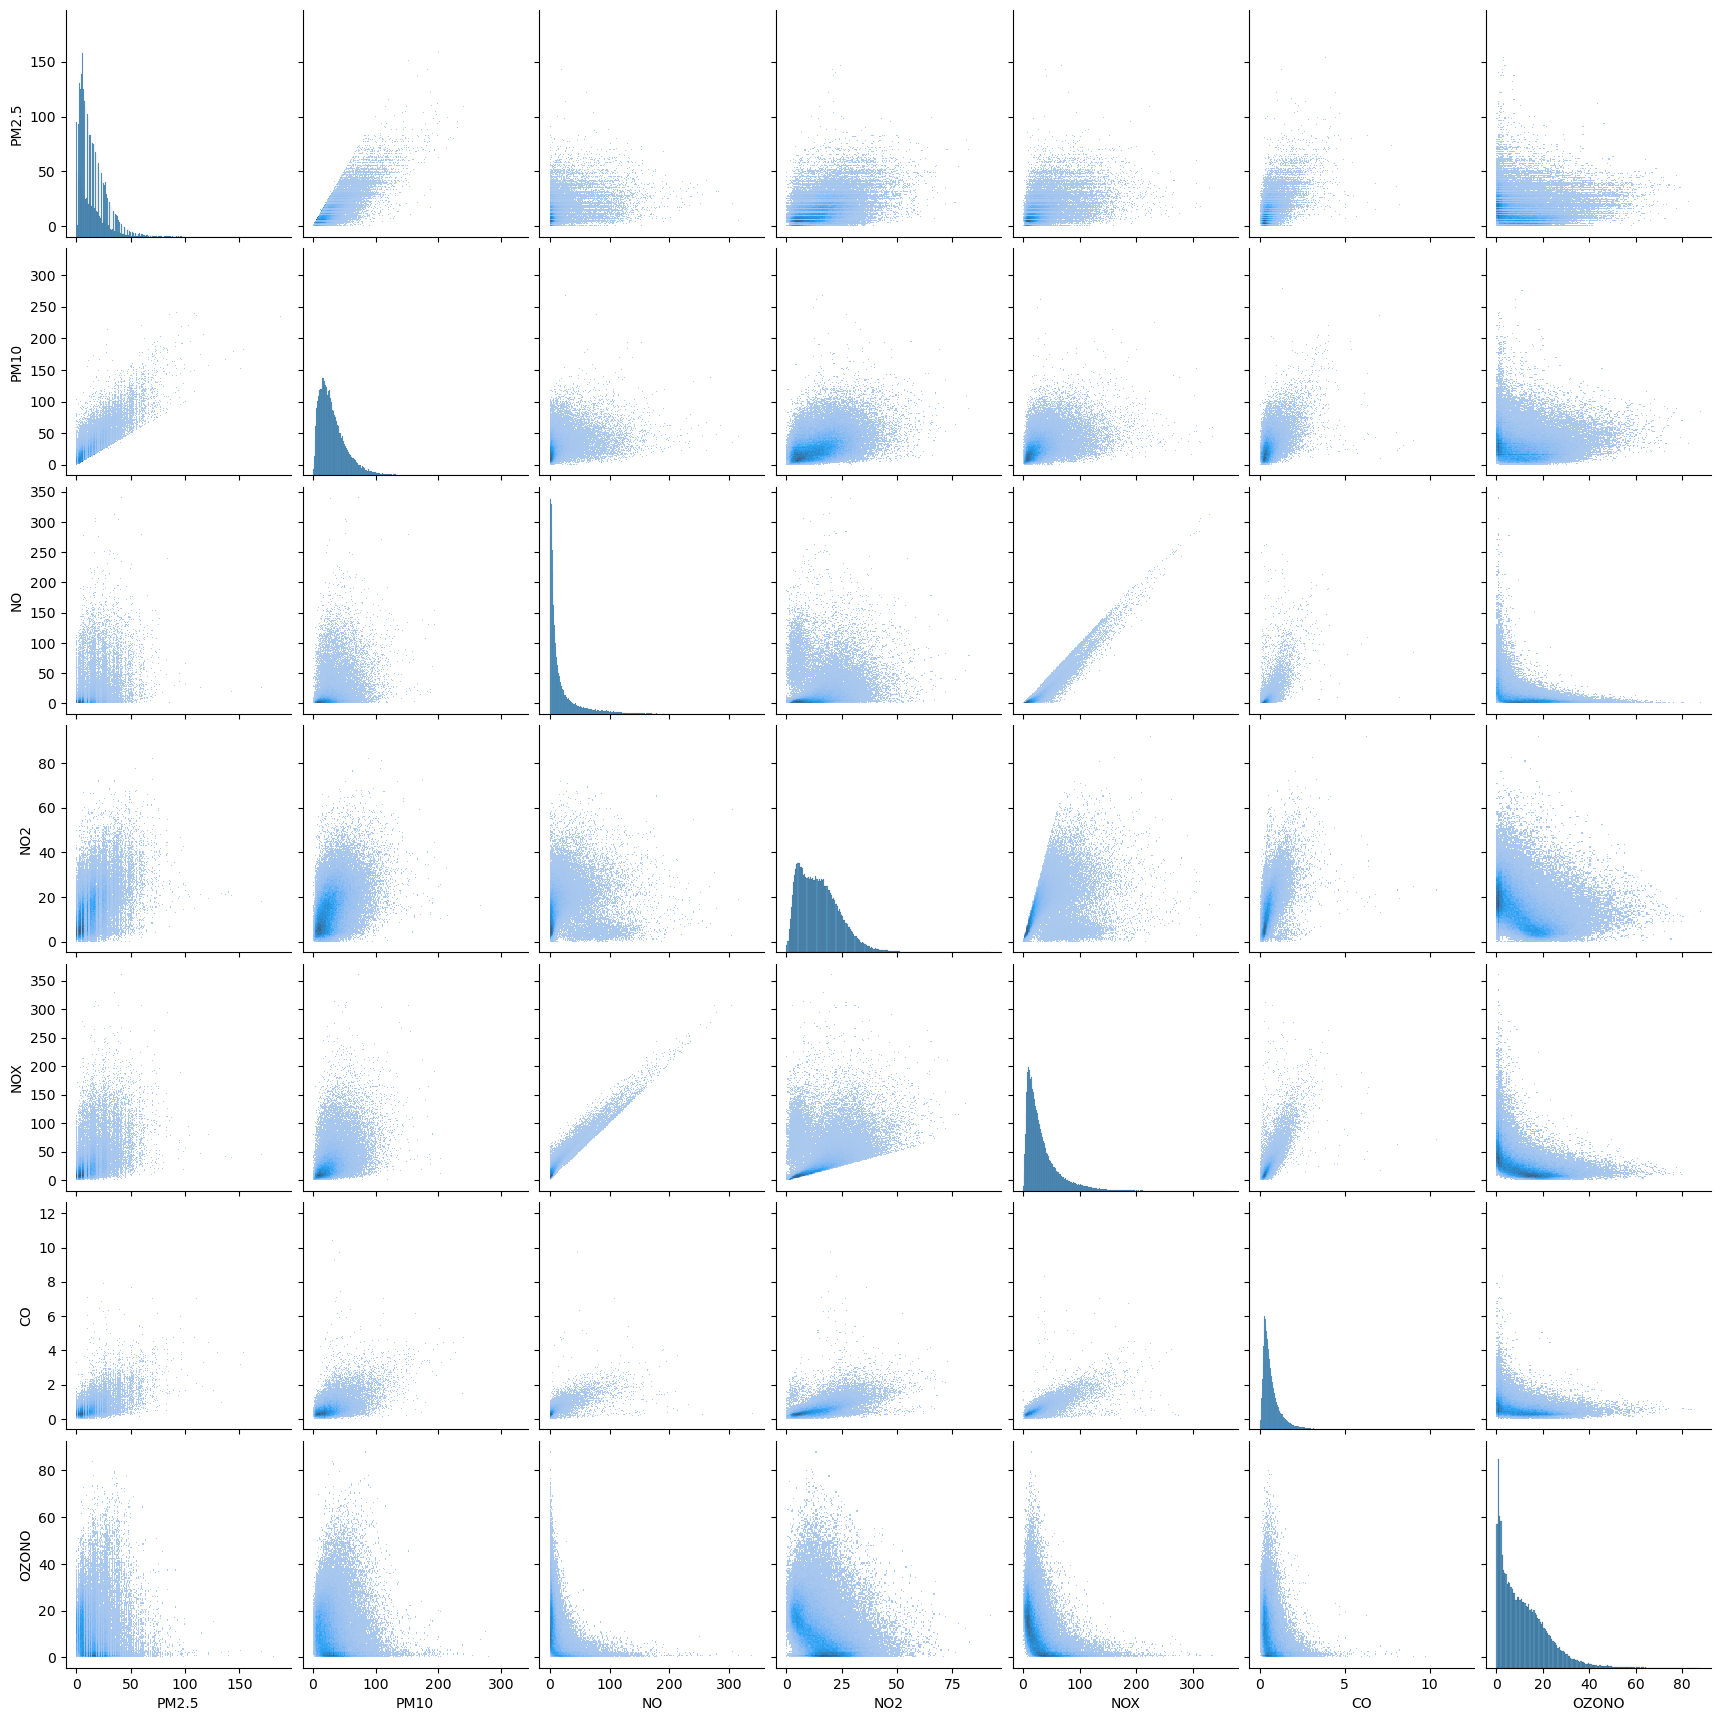

In [10]:
create_plot_pair(data , pollutants_list)

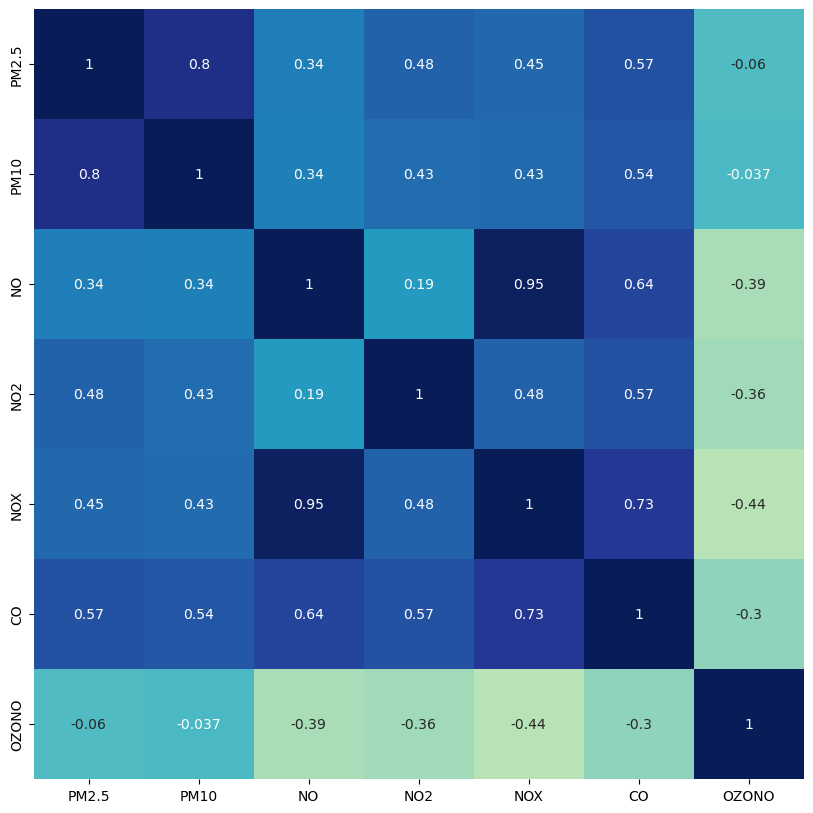

In [11]:
create_correlation(data ,  pollutants_list)

In [12]:
data['DateTime'] = pd.to_datetime(fix_dates(data, 'DateTime'), dayfirst=True)


In [13]:
from datetime import datetime
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 1, 31) 


create_time_series(data ,start_date  , end_date)


interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…